# Accessing FlyWire's segmentation and meshes

This notebook provides and overview of how to access the segmentation data released with the FlyWire connectome. It only covers release versions.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

## CloudVolume

[CloudVolume](https://github.com/seung-lab/cloud-volume) is a powerful Python library for accessing 3d volumetric data stored in the cloud (Google, AWS). You can install cloudvolume via

```
pip install cloud-volume
```

Cloudvolume is officially supports on Linux and MacOS; Windows is community supported is known to create challenges during the installation process.

In [19]:
import cloudvolume

## Segmentation access

The segmentation of each release is exported to a static format that can be easily interfaced with. The data is stored on Google Cloud at a resolution of (16, 16, 40) nm. It was produced at this resolution.

The data can be freely access but should not be used as part of an automated workflow that produces high traffic on this resources. Please reach out if that should be your use case.

In [3]:
# The cloud path for the 630 release version (1st public release)
seg_path = "precomputed://gs://flywire_v141_m630"

Instantiate a cloudvolume instance:

In [4]:
cv_seg = cloudvolume.CloudVolume(seg_path, use_https=True, fill_missing=True)

Cloudvolume loads the info file associated with the volume that contains information about its resolution and size. These parameters are directly available

In [5]:
cv_seg.resolution

Vec(16,16,40, dtype=int64)

In [6]:
cv_seg.bounds

Bbox([5100, 1440, 16],[59200, 29600, 7062], dtype=int32)

The data is multi-level. One can use a lower resolution of the data:

In [7]:
cv_seg_mip2 = cloudvolume.CloudVolume(seg_path, use_https=True, mip=2)
cv_seg_mip2.resolution

Vec(64,64,40, dtype=int64)

Reading of the data is facilitated through slicing similar to numpy areas. The last dimensions denotes the number of channel of which we only have one:

In [8]:
vol = cv_seg[32500:33000, 12500:13000, 2500:2510]
vol.shape

Decompressing: 100%|███████████████████████████| 20/20 [00:00<00:00, 909.13it/s]


(500, 500, 10, 1)

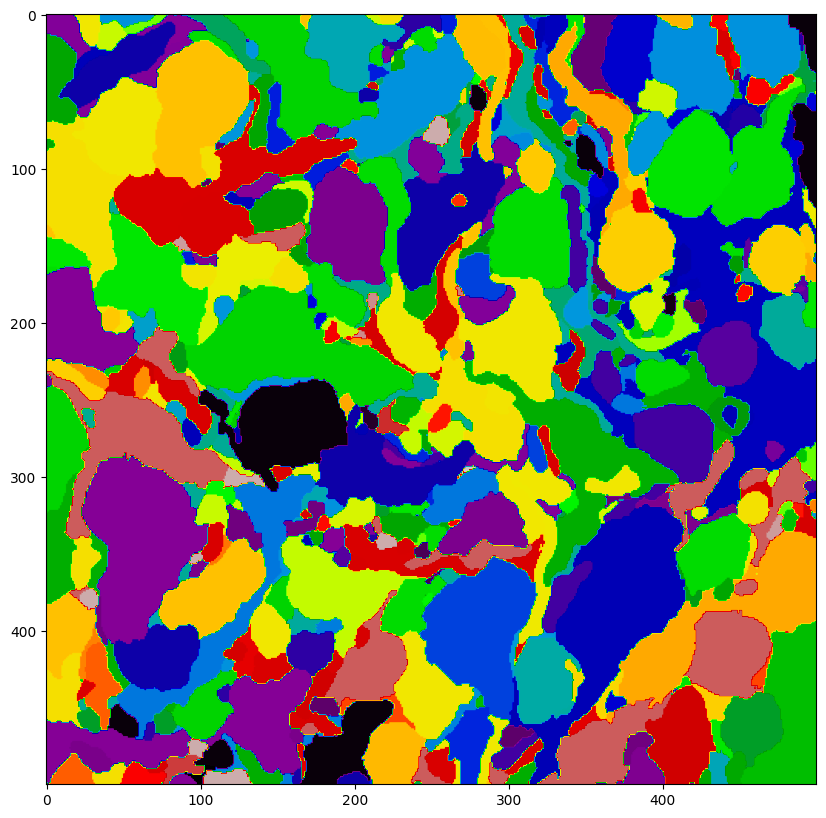

In [9]:
# Convenience function to map neuron IDs to nice colors
def remap_seg(seg, b=8, seed=23):    
    u_ids = np.unique(seg)
    np.random.seed(seed)
    np.random.shuffle(u_ids)
    mapping = np.vectorize(dict(zip(u_ids, np.random.randint(0, 2**b-1, size=len(u_ids)))).get)
    
    remapped_seg = mapping(seg).astype(int)
    
    return remapped_seg

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(remap_seg(vol[..., 0, 0]), cmap="nipy_spectral")

## EM imagery access

The EM data can be accessed in a very similar way to the segmentation data. The highest available resolution on Google Cloud is (8, 8, 40) nm. Please reach out should you have a use case that requires access to the (4, 4, 40) nm version of the data.

Notes on the data

1. The cloudvolume object will pretend to have a (4, 4, 40) nm image layer. That is a placeholder and was required for older versions of neuroglancer.

2. The image data used here is jpeg compressed. We have copies of the data that do not use lossy compression. Please reach out if you would like to access that data. 

3. FlyWire is based on a realigned version of the v14 imagery. We refer to FlyWire's version of the data as v14.1. There is mapping between the two made available through navis/fafbseg.

The data can be freely access but should not be used as part of an automated workflow that produces high traffic on this resources. Please reach out if that should be your use case.

In [10]:
# The cloud path the EM remains the same between versions
em_path = "precomputed://https://bossdb-open-data.s3.amazonaws.com/flywire/fafbv14"

Instantiate cloudvolume

In [11]:
cv_em = cloudvolume.CloudVolume(em_path, use_https=True, fill_missing=True, mip=1)

Reading works just like for the segmentation. Keep in mind that the resolution is most likely different between the two.

In [12]:
vol = cv_em[65000:66000, 25000:26000, 2500:2510]
vol.shape

Decompressing: 100%|███████████████████████████| 81/81 [00:00<00:00, 912.00it/s]


(1000, 1000, 10, 1)

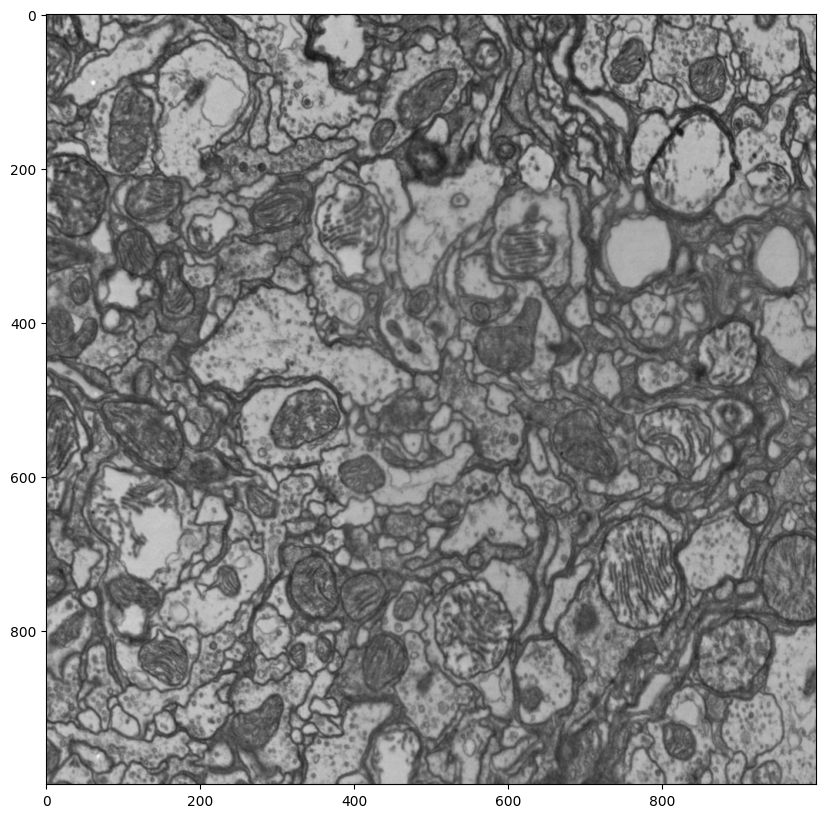

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(vol[..., 0, 0], cmap="gray")

## Mesh access

Meshes are available from the segmentation cloudvolume instance. They can be accessed for any ID:

In [14]:
mesh = cv_seg.mesh.get(720575940631693610)[720575940631693610]

This segmentation comes with multiple levels of details (LOD) for the meshes

In [15]:
mesh_lod2 = cv_seg.mesh.get(720575940631693610, lod=2)[720575940631693610]
mesh.vertices.shape, mesh_lod2.vertices.shape

((938587, 3), (230525, 3))

## MeshParty

MeshParty is not required but useful. [MeshParty](https://meshparty.readthedocs.io/en/latest/) is a library with convenience functions for loading and handling meshes and skeletons and also provides strong rendering capabilities (e.g. it was used for all renderings in figures 4-7 of the [flywire connectome manuscript](https://www.biorxiv.org/content/10.1101/2023.06.27.546656v2.full)). It can be installed via

```
pip install meshparty
```

MeshParty uses cloudvolume for cloud access. It uses a meta object for managing meshes locally. It has a cache (in memory) and can also cache meshes on disk.

In [16]:
import meshparty

In [17]:
from meshparty import trimesh_io
mesh_meta = trimesh_io.MeshMeta(cv_path=seg_path, cache_size=10)

In [18]:
%time mesh = mesh_meta.mesh(seg_id=720575940631693610)
%time mesh = mesh_meta.mesh(seg_id=720575940631693610)

CPU times: user 4.16 s, sys: 1.24 s, total: 5.4 s
Wall time: 3.89 s
CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 16.9 µs


Checkout MeshParty's rendering capabilities here: https://meshparty.readthedocs.io/en/latest/guide/visualization.html